In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('Data Source/AMZN.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define RNN Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 61ms/step - loss: 0.0768 - val_loss: 0.0040
Epoch 2/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 3/100
11/11 [==============================] - 0s 27ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 4/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0083
Epoch 5/100
11/11 [==============================] - 0s 23ms/step - loss: 0.0018 - val_loss: 0.0059
Epoch 6/100
11/11 [==============================] - 0s 26ms/step - loss: 0.0017 - val_loss: 0.0056
Epoch 7/100
11/11 [==============================] - 0s 19ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 8/100
11/11 [==============================] - 0s 30ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 9/100
11/11 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 10/100
11/11 [==============================] - 0s 47ms/step - loss: 0.0014 - val_loss: 0.0038

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 27ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 116.39383570135004
Testing RMSE: 116.56011310206172


In [14]:
from sklearn.metrics import mean_absolute_percentage_error

# Tính toán MAPE
mape = mean_absolute_percentage_error(y_pred, ytest)

print("MAPE:", mape)

MAPE: 0.9970479974407372


In [15]:
from sklearn.metrics import mean_absolute_error

# Tính toán MAE
mae = mean_absolute_error(y_pred, ytest)

print("MAE:", mae)

MAE: 115.3817415489209


In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[10:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=101
i=0
while(i<30):
    
    if(len(temp_input)>101):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.09919639 0.11067039 0.13317022 0.17996259 0.18157613 0.20712378
 0.18856816 0.18327932 0.16732329 0.19932501 0.20174528 0.19098843
 0.19869753 0.21698424 0.24405569 0.22890647 0.25203371 0.27014116
 0.33970235 0.25436439 0.24351787 0.24289039 0.22442443 0.20819942
 0.20255208 0.21985274 0.22128695 0.23437455 0.20739269 0.19887678
 0.17539097 0.18623748 0.18650639 0.16570976 0.16804044 0.17225356
 0.15378753 0.15342896 0.17825947 0.16795078 0.16615799 0.16947465
 0.15450467 0.14087932 0.15611821 0.17808015 0.18991272 0.22433477
 0.2145639  0.20344848 0.22944429 0.21232289 0.21241254 0.20721337
 0.20640664 0.19923535 0.22621722 0.24190434 0.25346799 0.24557964
 0.25938424 0.23383666 0.24244216 0.24342821 0.22325906 0.20452419
 0.24548998 0.24647603 0.24853773 0.24459358 0.26252172 0.25812928
 0.2863661  0.27964305 0.24701385 0.26861729 0.31200334 0.27283034
 0.24235257 0.25651574 0.25669506 0.25983247 0.27471286 0.27623673
 0.28331835 0.31532007 0.33315855 0.31594756 0.324

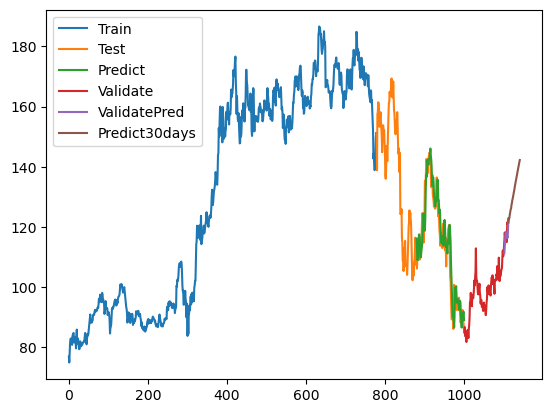

In [18]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()